In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Here reference level $C_{0}^{\alpha}L_{0}^{1-\alpha}$ refers to a steady state variable.

The utility is given by:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \lambda(\frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}) \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
\end{cases}
\end{equation}



If we reframe this a bit to make sure all the object value is positive:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} + (\lambda-1) \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \lambda \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \end{cases}
\end{equation}

In [2]:
#import package
import numpy as np
from datascience import Table
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import optimize
import time

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# import data
import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Import interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Import mortality table'
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

In [3]:
# parameter setting
ρ = 0.5 # 5?
α = 0.9
β = 1
λ = 3
C0 = 5.5 # 50?
L0 = 3/7
reference_level = np.power(C0,α)*np.power(L0,1-α)
Y1 = 8.5
Y2 = 3.0 # salary
# interest = 0.05
θ = 0.5

In [4]:
# print(np.power(C0,α)*np.power(L0,1-α))

In [5]:
Upper_grid = 201 #in ($0,000) dollars
Lower_grid = 1
grids = 101
M75 = np.linspace(Lower_grid, Upper_grid, grids)
print('α=0.9, ρ=0.5, λ=3, Y1=8.5, Y2=3.0')

Upper_grid_ref = 59 #in ($0,000) dollars
Lower_grid_ref = 1
Refc_grids = 30
CL_ref75 = np.linspace(Lower_grid_ref, Upper_grid_ref, Refc_grids)

α=0.9, ρ=0.5, λ=3, Y1=8.5, Y2=3.0


In [6]:
print('α, ρ, λ, Y1, Y2 = ', α, ρ, λ, Y1, Y2)
print('# of balance grids='+str(grids))
print('# of reference grids='+str(Refc_grids))

α, ρ, λ, Y1, Y2 =  0.9 0.5 3 8.5 3.0
# of balance grids=101
# of reference grids=30


# ========================== VFI =============================

## At age 75

In [7]:
def utility_1_vector(c, l, CL_ref75):
    utility = np.copy(c)
    criteria = np.power(c,α)*np.power(l,1-α) >= CL_ref75
    utility[criteria==True] = np.power(np.power(c[criteria==True],α) * np.power(l[criteria==True],1-α), 1-ρ)/(1-ρ) + \
                    (λ-1)*np.power(CL_ref75[criteria==True],1-ρ)/(1-ρ)
    utility[criteria==False] = λ * np.power(np.power(c[criteria==False],α) * np.power(l[criteria==False],1-α),1-ρ) / (1-ρ)
    return utility

def utility_1(c, l, CL_ref75):
    criteria = np.power(c,α)*np.power(l,1-α) >= CL_ref75
    if criteria==True:
        utility = np.power(np.power(c,α)*np.power(l,1-α),1-ρ)/(1-ρ) + (λ-1)*np.power(CL_ref75,1-ρ)/(1-ρ)
    else:
        utility = λ * np.power(np.power(c,α)*np.power(l,1-α),1-ρ)/(1-ρ)
    return utility

In [8]:
C75 = M75
L75 = np.ones(len(C75))
xx, zz = np.meshgrid(C75, CL_ref75)
yy, zz = np.meshgrid(L75, CL_ref75)
V75 = utility_1_vector(xx, yy, zz)

## Age 74

In [9]:
def value_funtion(control_variables, node, i, Y2, reference_level):
    C, L = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = utility_1(C, L, reference_level)
    M_next = (node + (1-L)*Y2 - C) * (1+interest)
    value2 = β * (1-mortalityTable['X'][73-i]) * interpo3(M_nt=M_next)
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1+Ex_value2) ## To minimise, use negative results

def solve(node, i, Y2, reference_level):
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, bounds=[(0,node+Y2), (2/7,1)], \
                            args=(node, i, Y2, reference_level), options={'maxiter':200, 'ftol':1e-20})  # method='L-BFGS-B'; method='SLSQP'

def solve2(node, i, Y2, reference_level):
    return optimize.differential_evolution(value_funtion, bounds = [(0,node+Y2), (2/7,1)],
                                           args=(node,i,Y2,reference_level), strategy='best1bin', maxiter=100, tol = 1e-10)

In [11]:
start_time = time.time()
Optimal_results_VFI = {'C75':C75,
                       'L75':L75,
                      'V75':V75}
for i in range(10): ## age 74-65 --> i from 0 to 9 (include)
#     def interpo(M_nt, reference_cl, dictionary=Optimal_results_VFI): # need to know which table to use
#             func = interpolate.interp2d(M75, C_ref75, Optimal_results_VFI['V%1d'%(75-i)], kind='linear')
#             V_next = func(M_nt, reference_c)
#             return V_next
#     def interpo2(M_nt, reference_c, dictionary=Optimal_results_VFI): # need to know which table to use
#             xx, yy = np.meshgrid(M75, C_ref75)
#             func = interpolate.Rbf(xx.ravel(), 
#                                    yy.ravel(), 
#                                    Optimal_results_VFI['V%1d'%(75-i)].ravel()) # interpolate on two lists
#             V_next = func(M_nt, [reference_c]*len(M_nt))
#             return V_next
    def interpo3(M_nt, dictionary=Optimal_results_VFI): # need to know which table to use
            func = interpolate.interp1d(M75, Optimal_results_VFI['V%1d'%(75-i)][j], \
                                        kind='linear', fill_value='extrapolate')
            V_next = func(M_nt)
            return V_next
    Mx = M75
    Cx = np.zeros((len(CL_ref75),len(M75)))
    Lx = np.zeros((len(CL_ref75),len(M75)))
    Vx = np.zeros((len(CL_ref75),len(M75)))
    for j, C0 in enumerate(CL_ref75):# to increase a loop here we can use interp1d instead of 2d that may cause trouble
        print('the %1d th reference'%(j))
        for k, node in enumerate(Mx):
            guess_con = 1
            guess_lei = 0.5
            initial_guess = [guess_con, guess_lei] #[guess_con, guess_theta]
            opt = solve2(node, i, Y2, C0)
            while not opt.success:
                guess_con += 0.5
                initial_guess = [guess_con, guess_lei] #[guess_con, guess_theta]
                opt = solve2(node, i, Y2, C0)
#                 print(opt.success)
            Cx[j][k], Lx[j][k]= opt.x
            Vx[j][k] = - opt.fun # to minimize, previous use negative value function
    Optimal_results_VFI['C%1d'%(74-i)] = Cx
    Optimal_results_VFI['L%1d'%(74-i)] = Lx
    Optimal_results_VFI['V%1d'%(74-i)] = Vx
    print('age%1d_finished!'%(74-i))
print("--- %s seconds ---" % (time.time() - start_time))

the 0 th reference
the 1 th reference
the 2 th reference
the 3 th reference
the 4 th reference
the 5 th reference
the 6 th reference
the 7 th reference
the 8 th reference
the 9 th reference
the 10 th reference
the 11 th reference
the 12 th reference
the 13 th reference
the 14 th reference
the 15 th reference
the 16 th reference
the 17 th reference
the 18 th reference
the 19 th reference
the 20 th reference
the 21 th reference
the 22 th reference
the 23 th reference
the 24 th reference
the 25 th reference
the 26 th reference
the 27 th reference
the 28 th reference
the 29 th reference
age74_finished!
the 0 th reference
the 1 th reference
the 2 th reference
the 3 th reference
the 4 th reference
the 5 th reference
the 6 th reference
the 7 th reference
the 8 th reference
the 9 th reference
the 10 th reference
the 11 th reference
the 12 th reference
the 13 th reference
the 14 th reference
the 15 th reference
the 16 th reference
the 17 th reference
the 18 th reference
the 19 th reference
the 

In [29]:
Optimal_results_VFI['L65']

array([[0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.2857143 , 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       ...,
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429]])

In [12]:
def value_funtion2(control_variables, node, i, Y1, reference_level):
    C, L = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = utility_1(C, L, reference_level)
    M_next = (node + (1-L)*Y1 - C) * (1+interest) # now it becomes a vector
    value2 = β * interpo4(M_nt=M_next) * (1-mortalityTable['X'][63-i])
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    if C <= Y1*(1-L):
        return - (value1 + Ex_value2) ## To minimise, use negative results
    else:
        return 100

def solve3(node, i, Y1, reference_level):
    return optimize.minimize(value_funtion2, initial_guess, args=(node, i, Y1, reference_level), method='SLSQP', tol=None, \
                             bounds=[(0,Y1), (2/7,1)], options={'maxiter':100, 'ftol':1e-20})  
# method='L-BFGS-B'; method='SLSQP'

def solve4(node, i, Y1, reference_level):
    return optimize.differential_evolution(value_funtion2, bounds = [(0,Y1), (2/7,1)],
                                           args=(node,i,Y1,reference_level), strategy='best1bin', maxiter=100, tol = 1e-10)

In [13]:
start_time = time.time()
Optimal_results_VFI_55_63 = {'C65':Optimal_results_VFI['C65'],
                             'L65':Optimal_results_VFI['L65'],
                             'V65':Optimal_results_VFI['V65']  
}

for i in range(10): ## age 64-55 --> i from 0 to 9 (include)
#     def interpo(M_nt, reference_c, dictionary=Optimal_results_VFI_55_63): # need to know which table to use
#             func = interpolate.interp2d(M75, C_ref75, Optimal_results_VFI_55_63['V%1d'%(65-i)], \
#                                         kind='linear')
#             V_next = func(M_nt, reference_c)
#             return V_next
    def interpo4(M_nt, dictionary=Optimal_results_VFI_55_63): # need to know which table to use
            func = interpolate.interp1d(M75, Optimal_results_VFI_55_63['V%1d'%(65-i)][j], \
                                        kind='linear', fill_value='extrapolate')
            V_next = func(M_nt)
            return V_next
    Mx = M75
    Cx = np.zeros((len(CL_ref75),len(M75)))
    Vx = np.zeros((len(CL_ref75),len(M75)))
    for j, C0 in enumerate(CL_ref75):# j start with index=1
        for k, node in enumerate(Mx):
            guess_con = 1
            guess_lei = 0.5
            initial_guess = [guess_con, guess_lei] #[guess_con, guess_theta]
            opt = solve4(node, i, Y1, C0)
            while not opt.success:
                guess_con += 0.5
                initial_guess = [guess_con, guess_lei] #[guess_con, guess_theta]
                opt = solve4(node, i, Y1, C0)
#                 print(opt.success)
            Cx[j][k], Lx[j][k]= opt.x
            Vx[j][k] = - opt.fun # to minimize, previous use negative value function
    Optimal_results_VFI_55_63['C%1d'%(64-i)] = Cx
    Optimal_results_VFI_55_63['L%1d'%(64-i)] = Lx
    Optimal_results_VFI_55_63['V%1d'%(64-i)] = Vx
    print('age%1d_finished!'%(64-i))
print("--- %s seconds ---" % (time.time() - start_time))

age64_finished!
age63_finished!
age62_finished!
age61_finished!
age60_finished!
age59_finished!
age58_finished!
age57_finished!
age56_finished!
age55_finished!
--- 10194.437809467316 seconds ---


# Write the optimal results into a CSV file!

In [14]:
aa, bb = np.meshgrid(M75, CL_ref75)

In [15]:
Optimal_results_VFI_table = Table().with_column('M74', aa.ravel(),
                                                'R74', bb.ravel(),
                                                'C74', Optimal_results_VFI['C74'].ravel(),
                                                'L74', Optimal_results_VFI['L74'].ravel(),
                                                'V74', Optimal_results_VFI['V74'].ravel(),
                                               )
for i in range(9):#0-9, age 74-65
    age = 73-i
    Optimal_results_VFI_table = Optimal_results_VFI_table.with_column(
                                'M%1d'%(age),aa.ravel(),
                                'R%1d'%(age),bb.ravel(),
                                'C%1d'%(age),Optimal_results_VFI['C%1d'%(age)].ravel(),
                                'L%1d'%(age),Optimal_results_VFI['L%1d'%(age)].ravel(),
                                'V%1d'%(age),Optimal_results_VFI['V%1d'%(age)].ravel(),
                                )
    
Optimal_results_VFI_table.show(2)

M74,R74,C74,L74,V74,M73,R73,C73,L73,V73,M72,R72,C72,L72,V72,M71,R71,C71,L71,V71,M70,R70,C70,L70,V70,M69,R69,C69,L69,V69,M68,R68,C68,L68,V68,M67,R67,C67,L67,V67,M66,R66,C66,L66,V66,M65,R65,C65,L65,V65
1,1,1.61122,0.285714,12.5469,1,1,1.68521,0.285714,18.9512,1,1,1.72145,0.285714,25.2498,1,1,1.73485,0.285714,31.4697,1,1,1.73322,0.285714,37.6309,1,1,1.7209,0.285714,43.7488,1,1,1.70066,0.285714,49.8353,1,1,1.67445,0.285714,55.9006,1,1,1.64328,0.285714,61.9541,1,1,1.60808,0.285714,68.005
3,1,2.29153,0.285714,13.7912,3,1,2.26328,0.285714,20.1779,3,1,2.22717,0.285714,26.4688,3,1,2.19791,0.285714,32.6871,3,1,2.14402,0.285714,38.8512,3,1,2.08279,0.285714,44.9752,3,1,2.027,0.285714,51.0708,3,1,1.9674,0.285714,57.1476,3,1,1.89922,0.285714,63.2147,3,1,1.82932,0.285714,69.2814


In [16]:
Optimal_results_VFI_55_63_table = Table().with_column('M64', aa.ravel(),
                                                'R64', bb.ravel(),
                                                'C64', Optimal_results_VFI_55_63['C64'].ravel(),
                                                'L64', Optimal_results_VFI_55_63['L64'].ravel(),
                                                'V64', Optimal_results_VFI_55_63['V64'].ravel(),
                                               )
for i in range(9):#0-9, age 64-55
    age = 63-i
    Optimal_results_VFI_55_63_table = Optimal_results_VFI_55_63_table.with_column(
                                'M%1d'%(age),aa.ravel(),
                                'R%1d'%(age),bb.ravel(),
                                'C%1d'%(age),Optimal_results_VFI_55_63['C%1d'%(age)].ravel(),
                                'L%1d'%(age),Optimal_results_VFI_55_63['L%1d'%(age)].ravel(),
                                'V%1d'%(age),Optimal_results_VFI_55_63['V%1d'%(age)].ravel(),
                                )
    
Optimal_results_VFI_55_63_table.show(2)

M64,R64,C64,L64,V64,M63,R63,C63,L63,V63,M62,R62,C62,L62,V62,M61,R61,C61,L61,V61,M60,R60,C60,L60,V60,M59,R59,C59,L59,V59,M58,R58,C58,L58,V58,M57,R57,C57,L57,V57,M56,R56,C56,L56,V56,M55,R55,C55,L55,V55
1,1,1.90967,0.285714,76.5343,1,1,2.09496,0.285714,84.8577,1,1,2.23109,0.285714,93.0714,1,1,2.33075,0.285714,101.218,1,1,2.39918,0.285714,109.323,1,1,2.44032,0.285714,117.408,1,1,2.46631,0.285714,125.485,1,1,2.4747,0.285714,133.566,1,1,2.46962,0.285714,141.657,1,1,2.45371,0.285714,149.766
3,1,2.05564,0.285714,77.7014,3,1,2.23378,0.285714,85.9682,3,1,2.36017,0.285714,94.144,3,1,2.45337,0.285714,102.264,3,1,2.51491,0.285714,110.354,3,1,2.5514,0.285714,118.429,3,1,2.56911,0.285714,126.501,3,1,2.57093,0.285714,134.58,3,1,2.55986,0.285714,142.674,3,1,2.53683,0.285714,150.788


In [18]:
Optimal_results_VFI_table.to_csv('Model6_VFI_74-65.csv')
Optimal_results_VFI_55_63_table.to_csv('Model6_VFI_64-55.csv')

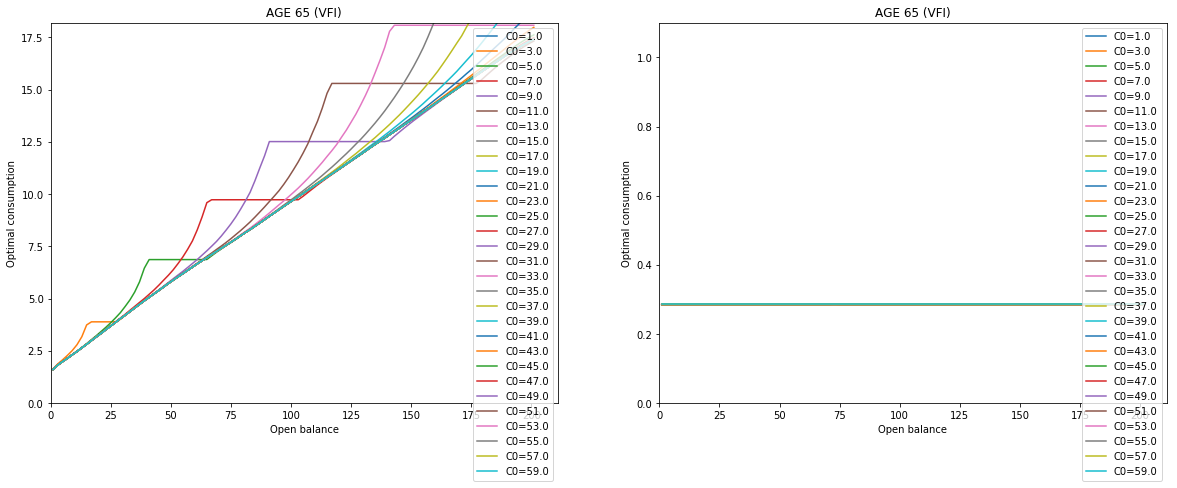

In [28]:
# SELECT YOUR AGE HERE TO PLOT OPTIMAL CONSUMPTION AND LEISURE (65-74)
AGE = 65

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(Refc_grids):
    REF = Lower_grid_ref+(Upper_grid_ref-Lower_grid_ref)/(Refc_grids-1)*i
    plt.plot(M75, Optimal_results_VFI['C%1d'%(AGE)][i], label='C0=%1.1f'%(REF))
    plt.legend(loc='upper right')
    plt.xlabel('Open balance')
    plt.ylabel('Optimal consumption')
    plt.title('AGE %1d (VFI)'%(AGE))
    plt.xlim(0, )
    plt.ylim(0, )
    
plt.subplot(1,2,2)
for i in range(Refc_grids):
    REF = Lower_grid_ref+(Upper_grid_ref-Lower_grid_ref)/(Refc_grids-1)*i
    plt.plot(M75, Optimal_results_VFI['L%1d'%(AGE)][i], label='C0=%1.1f'%(REF))
    plt.legend(loc='upper right')
    plt.xlabel('Open balance')
    plt.ylabel('Optimal consumption')
    plt.title('AGE %1d (VFI)'%(AGE))
    plt.xlim(0, )
    plt.ylim(0, 1.1)